# 3. Introduction to Models

- In AML, "Model" is a mathematical function that takes atomistic structure as input and calculates the property of intereset as output.
  $$
  P = f(z, \mathbf{R}) \quad (z \in \mathbb{Z}^N, \mathbf{R} \in \mathbb{R}^{N\times3})
  $$
  where $N$ is number of atoms, $z$ is atomic numbers in the structure, and $\mathbf{R}$ is cartesian coordinates of atoms.
- For example, the model is interatomic potential model when $P$ is the potential energy of given $z$ and $\mathbf{R}$.


## 3.1 Implemented models in `aml`

- Currently only interatomic potential is implemented (as `InterAtomicPotential`)
- `InterAtomicPotential` requires `energy_model` as input, which computes potential energy corresponding to input `AtomsGraph`.

### 3.1.1 Enegy model tutorial

- Has a base class `BaseEnergyModel`
- All energy models require `species` and `cutoff`.
  - Usually `cutoff=5.0` is fine, and it is default value
- Below the (untrained) `SchNet` model is demonstrated to compute potential energy of ethanol

In [1]:
import ase.build
from aml.data import AtomsGraph
from aml.models.energy_models import SchNet

atoms = ase.build.molecule("CH3CH2OH")  # ethanol
data = AtomsGraph.from_ase(atoms, 5.0)  # Graph with neighborlist cutoff=5.0
energy_model = SchNet(species=["C", "H", "O"], cutoff=5.0)

predicted_energy = energy_model(data) # Compute energy
print(f"E = {predicted_energy.item():.3f} eV")

E = -4.316 eV


- Energy model is `Configurable`, so config dict can be extracted

In [2]:
config = energy_model.get_config()
config

{'@name': 'schnet',
 'species': ['C', 'H', 'O'],
 'cutoff': 5.0,
 'hidden_channels': 128,
 'n_filters': 128,
 'n_interactions': 6,
 'rbf_type': 'gaussian',
 'n_rbf': 50,
 'trainable_rbf': False}

In [3]:
from aml.models.energy_models import BaseEnergyModel

energy_model = BaseEnergyModel.from_config(config)
energy_model.name

'schnet'

### 3.1.2 `InterAtomicPotential` tutorial

- `InterAtomicPotential` takes `energy_model`
- It computes potential energy and the energy-derived properties (force, stress, hessian)
- Calculation of force, stress, hessian are optional. Only force calculation is enabled by default
  - Stress cannot be calculated for non-periodic structures 
- returns the dictionary of outputs

In [4]:
from aml.models import InterAtomicPotential

model = InterAtomicPotential(
    energy_model,
    compute_force=True,  # True by default
)
output = model(data)
print(output)

{'energy': tensor([-4.4306], grad_fn=<ScatterAddBackward0>), 'force': tensor([[-6.8154e-02,  5.1513e-04, -2.2352e-07],
        [ 3.4403e-01,  2.2513e-01, -1.6391e-07],
        [-7.6778e-01, -2.7903e-01, -6.3330e-08],
        [ 3.6710e-02,  9.8374e-01, -1.4901e-07],
        [-4.0971e-01, -1.7996e-01, -8.5739e-01],
        [-4.0971e-01, -1.7996e-01,  8.5739e-01],
        [-1.0081e+00, -8.6414e-01, -4.4703e-08],
        [ 1.1414e+00,  1.4685e-01, -7.2049e-01],
        [ 1.1414e+00,  1.4685e-01,  7.2049e-01]], grad_fn=<NegBackward0>)}


In [5]:
# Hessian
model.compute_hessian = True
output = model(data)
output["hessian"].shape

torch.Size([27, 27])

### 3.1.3 Interface `InterAtomicPotential` of to `ase`

- `aml.simulations.AMLCalculator` is interface to `ase` library
- `InterAtomicPotential` can be used to calculate on `Atoms` using `AMLCalculator`

In [6]:
import torch
from aml.simulations import AMLCalculator

device = "cuda" if torch.cuda.is_available() else "cpu"

calc = AMLCalculator(model=model, device=device)
atoms.calc = calc

E = atoms.get_potential_energy()
F = atoms.get_forces()
E, F

(-4.4306488037109375,
 array([[-6.8154104e-02,  5.1513314e-04, -2.2351742e-07],
        [ 3.4402820e-01,  2.2513062e-01, -1.6391277e-07],
        [-7.6778185e-01, -2.7903169e-01, -6.3329935e-08],
        [ 3.6710083e-02,  9.8373944e-01, -1.4901161e-07],
        [-4.0970734e-01, -1.7995551e-01, -8.5739279e-01],
        [-4.0970770e-01, -1.7995591e-01,  8.5739326e-01],
        [-1.0081095e+00, -8.6414444e-01, -4.4703484e-08],
        [ 1.1413611e+00,  1.4685114e-01, -7.2048789e-01],
        [ 1.1413612e+00,  1.4685126e-01,  7.2048813e-01]], dtype=float32))

- Of course the model is not correct since it is not trained
- Consider the potential energy surface of -CH<sub>3</sub> torsion in ethanol:

In [7]:
import numpy as np

def make_ethanol_ch3_rotation_traj():
    atoms = ase.build.molecule("CH3CH2OH")
    images = []
    angles = np.linspace(0, 360, 500)
    for angle in angles:
        new = atoms.copy()
        new.rotate_dihedral(4, 1, 0, 7, angle, indices=[6, 0, 7, 8])
        images.append(new)
    return angles, images

angles, images = make_ethanol_ch3_rotation_traj()
energies = np.array([calc.get_potential_energy(atoms) for atoms in images])

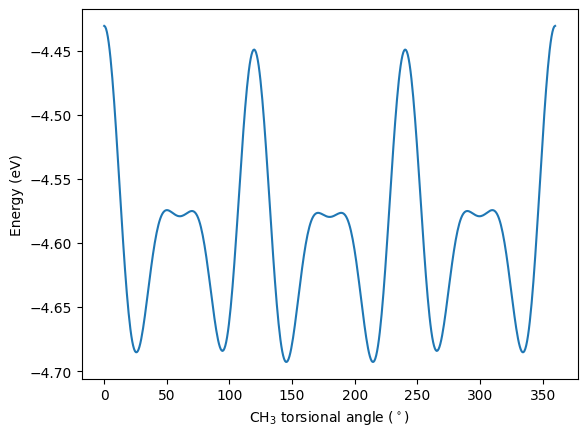

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("CH$_3$ torsional angle ($^\circ$)")
plt.ylabel("Energy (eV)")
plt.plot(angles, energies)
plt.show()

It is clear that the predicted PES is totally wrong!